In [2]:
import json

# Kaggle Credential's file
kaggle = open('kaggle.json')        
kaggle_dict = json.load(kaggle) 

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_dict['username']
os.environ['KAGGLE_KEY'] = kaggle_dict['key']

In [4]:
!kaggle datasets download msambare/fer2013

 68% 41.0M/60.3M [00:01<00:00, 42.5MB/s]
100% 60.3M/60.3M [00:01<00:00, 51.0MB/s]


In [ ]:
# unzip the dataset
!unzip fer2013.zip

## Image Pre-processing

**Image augmentation** artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.
<br><br>
Using *ImageDataGenerator* API of keras for Image augmentation

In [6]:
import keras
from keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,       
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,  
                                   horizontal_flip = True,
                                   rotation_range = 15,    
                                   shear_range = 0.2,
                                   zoom_range = 0.1 )

test_datagen = ImageDataGenerator(rescale = 1./255)

## Loading Dataset

In [8]:
train_generator = train_datagen.flow_from_directory('/content/train', 
                                                    target_size=(48, 48), 
                                                    batch_size=128, 
                                                    class_mode='categorical',
                                                    color_mode='grayscale',
                                                    shuffle=True,
                                                    seed=42)

test_generator = test_datagen.flow_from_directory('/content/test', 
                                                        target_size=(48, 48), 
                                                        batch_size=128, 
                                                        class_mode='categorical',
                                                        color_mode='grayscale',
                                                        shuffle=True,
                                                        seed=42)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Classes Index
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Building Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [44]:
no_of_classes = 7

model1 = Sequential()

#1st CNN layer
model1.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

#2nd CNN layer
model1.add(Conv2D(128,(5,5),padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout (0.25))

#3rd CNN layer
model1.add(Conv2D(512,(3,3),padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout (0.25))

#4th CNN layer
model1.add(Conv2D(512,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

#Fully connected 1st layer
model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))


# Fully connected layer 2nd layer
model1.add(Dense(512))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Dense(no_of_classes, activation='softmax'))

Compiling the Model

In [45]:
model1.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [46]:
checkpoint = ModelCheckpoint("./model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=7,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.01)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

Fitting Model with out Train and Test Images

In [47]:
history = model1.fit(train_generator,
                    steps_per_epoch= train_generator.n // train_generator.batch_size,
                    epochs=60,
                    validation_data = test_generator,
                    validation_steps = test_generator.n // test_generator.batch_size,
                    callbacks = callbacks_list
                   )

Epoch 1/60
224/224 [==============================] - ETA: 0s - loss: 1.9172 - accuracy: 0.2394
Epoch 1: val_accuracy improved from -inf to 0.24819, saving model to ./model1.h5
224/224 [==============================] - 27s 115ms/step - loss: 1.9172 - accuracy: 0.2394 - val_loss: 1.8139 - val_accuracy: 0.2482 - lr: 0.0100
Epoch 2/60
224/224 [==============================] - ETA: 0s - loss: 1.7208 - accuracy: 0.3110
Epoch 2: val_accuracy improved from 0.24819 to 0.26395, saving model to ./model1.h5
224/224 [==============================] - 25s 112ms/step - loss: 1.7208 - accuracy: 0.3110 - val_loss: 2.3905 - val_accuracy: 0.2640 - lr: 0.0100
Epoch 3/60
224/224 [==============================] - ETA: 0s - loss: 1.5497 - accuracy: 0.3915
Epoch 3: val_accuracy improved from 0.26395 to 0.36844, saving model to ./model1.h5
224/224 [==============================] - 25s 110ms/step - loss: 1.5497 - accuracy: 0.3915 - val_loss: 1.5997 - val_accuracy: 0.3684 - lr: 0.0100
Epoch 4/60
224/224 [==

## Visualizing and Evaluating Model

Loading the Saved Model

In [69]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('model1.h5')

### Plotting Model

In [49]:
from keras.utils.vis_utils import plot_model

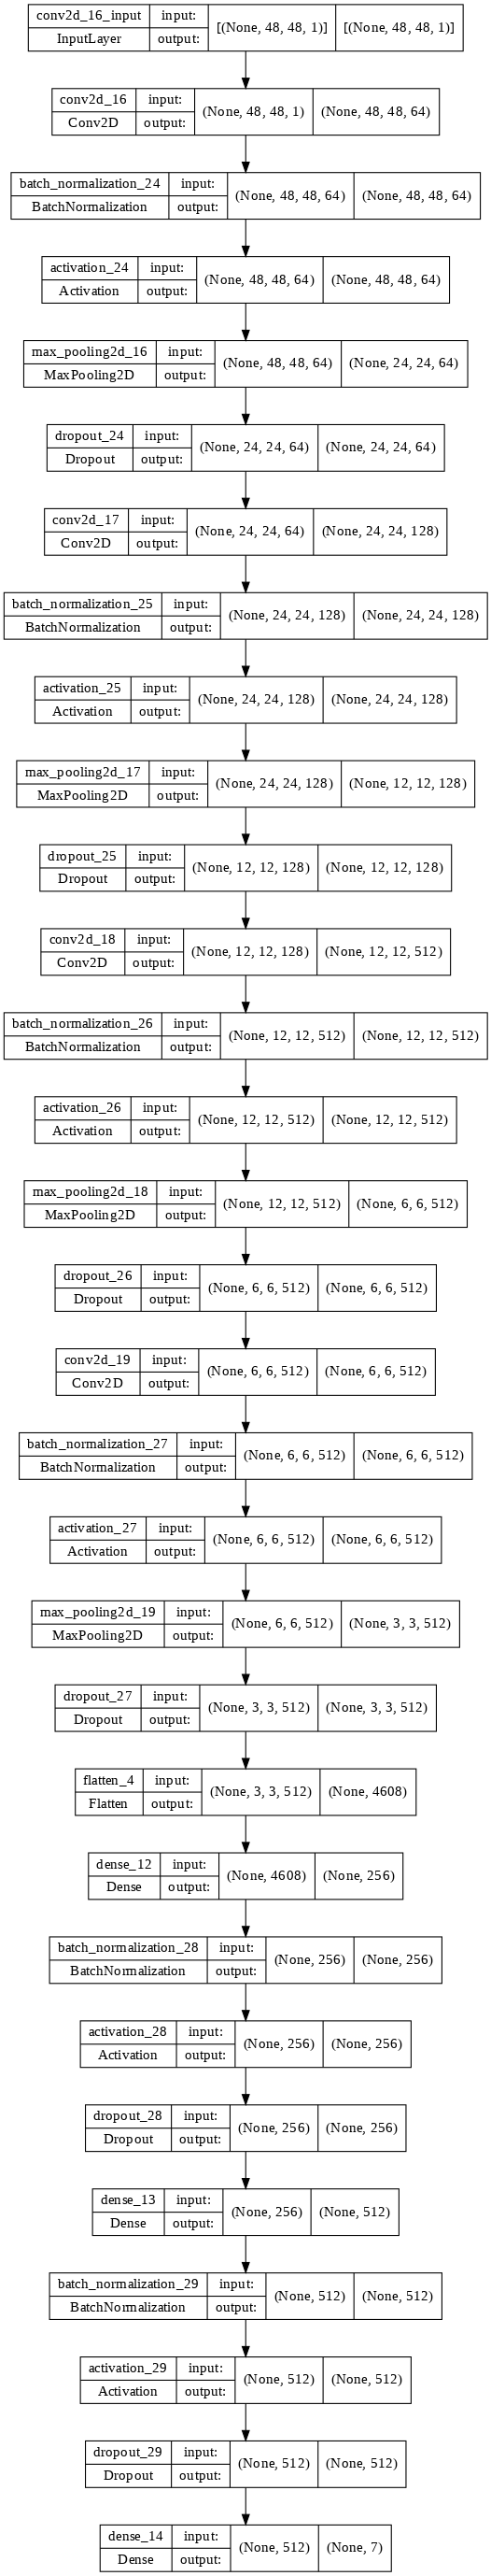

In [70]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=78)

### Plotting Accuracy

In [55]:
import matplotlib.pyplot as plt

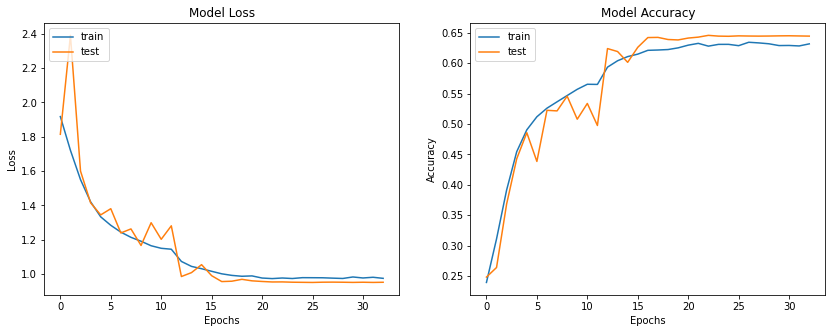

In [56]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluating Final Model

In [71]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 2s 37ms/step - loss: 0.9536 - accuracy: 0.6460
final train accuracy = 66.31 , validation accuracy = 64.60


### Plotting Confusion Matrix

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix

**Training Dataset**

Confusion Matrix
[[ 521   29  333 1069  833  763  447]
 [  67    4   32  126   82   74   51]
 [ 554   38  329 1081  801  794  500]
 [ 960   65  612 1899 1389 1430  860]
 [ 669   52  442 1253 1004  955  590]
 [ 635   42  438 1234  931  956  594]
 [ 426   28  256  875  622  612  352]]


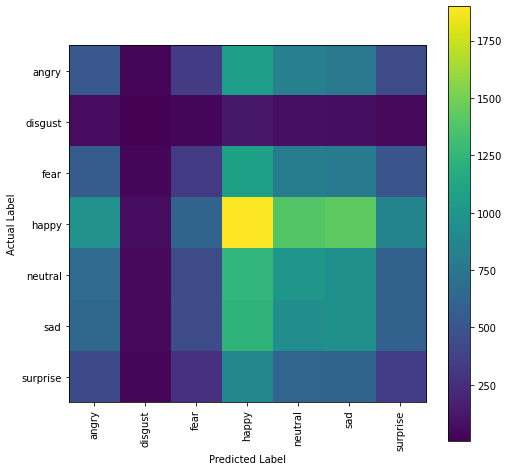

In [68]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

target_names = list(class_labels.values())

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

**Test Dataset**

Confusion Matrix
[[157   5  75 254 243 105 119]
 [ 16   1   7  31  23  17  16]
 [141   5  97 249 247 155 130]
 [260  13 135 471 387 297 211]
 [205   9 100 298 276 197 148]
 [176  13 109 299 289 196 165]
 [119   9  73 210 180 133 107]]


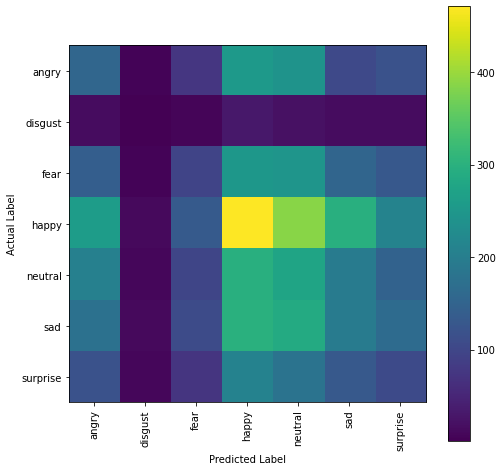

In [67]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)

target_names = list(class_labels.values())

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()